# Global Malnutrition Analysis

In this project, we have analyzed several sources of data relevant to malnutrition amongst children ranging from the ages of infant to 5 years old. The major components of our analysis is as follows: 

1. Extracting data from various sources including UNICEF, World Bank and more (listed below) 
2. Combining malnutrition data into a single dataframe with information regarding wasting, overweight and stunting conditions amongst the global population of children from 1978 to 2021 
3. Analysing countries with the highest prevalence of malnutrition 
4. Developing a world heat map visualization to see the global malnutrition trend over the years 
5. Assessing a relationship, if any, between COVID deaths experienced by the country and prevalence of malnutrition among children

## Data Sources

1. The malnutrtion data is from UNICEF.org and it has the ratio of kids under 5 with stunt/severe stunting, wasted/severe wasted, and overweight problems at country-level from 1970 to 2021.(datalink: https://data.unicef.org/resources/data_explorer/unicef_f/?ag=UNICEF&df=GLOBAL_DATAFLOW&ver=1.0&dq=.NT_ANT_HAZ_NE2+NT_ANT_HAZ_NE3..&startPeriod=2016&endPeriod=2021). 

2. Country Geopandas data 

3. COVID deaths data 

4. Continent & Country Data 

## 1. Data Gathering

In [52]:
# download necessary packages

import numpy as np  #calculation
import pandas as pd  #dataframe
import scipy as sp #calculation
from scipy.interpolate import interp1d #smooth plot
import seaborn as sns #graph
import matplotlib.pyplot as plt #plot
from sklearn import linear_model #linear regression
import statsmodels.api as sm #linear regression model
from seaborn import heatmap #map
import os
import geopandas as gpd
import descartes
import warnings
warnings.filterwarnings('ignore')

In [3]:
#download datasets and show headlines

In [4]:
wasted_data = pd.read_csv("Wasted_Data.csv")
display(wasted_data[:3])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_NE2: Weight-for-height <-2 SD (wast...,F: Female,2004,9.3,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old
1,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_NE2: Weight-for-height <-2 SD (wast...,F: Female,2013,8.7,0: Units,PCNT: %,RA: Reanalysed,F: Free,...,2080089.9,Oedema data was not considered in the analysis...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Afghanistan National Nutrition Survey 2013,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old
2,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_NE2: Weight-for-height <-2 SD (wast...,F: Female,2018,4.1,0: Units,PCNT: %,RA: Reanalysed,F: Free,...,9593.1,Oedema data was not considered in the analysis...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Afghanistan Health Survey 2018,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old


In [5]:
# make sure the data downloaded is for wasting only
wasted_data['INDICATOR:Indicator'].unique() 

array(['NT_ANT_WHZ_NE2: Weight-for-height <-2 SD (wasting)'], dtype=object)

In [6]:
ser_wasted_data=pd.read_csv("Severe_Wasted_Data.csv")
display(ser_wasted_data[:1])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_NE3: Weight-for-height <-3 SD (seve...,F: Female,2004,4.3,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,2004-2018,Y0T4: Under 5 years old


In [7]:
ser_wasted_data['INDICATOR:Indicator'].unique() #for severe wasting only

array(['NT_ANT_WHZ_NE3: Weight-for-height <-3 SD (severe wasting)'],
      dtype=object)

In [8]:
stunted_data = pd.read_csv("Stunt_Data.csv")
display(stunted_data[:1])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_HAZ_NE2: Height-for-age <-2 SD (stunting),F: Female,2004,58.5,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old


In [9]:
stunted_data['INDICATOR:Indicator'].unique() #stunting only

array(['NT_ANT_HAZ_NE2: Height-for-age <-2 SD (stunting)'], dtype=object)

In [10]:
ser_stunted_data = pd.read_csv("Severe_Stunt_Data.csv")
display(ser_stunted_data[:1])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_HAZ_NE3: Height-for-age <-3 SD (Severe ...,F: Female,2004,30.9,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,2004-2018,Y0T4: Under 5 years old


In [11]:
ser_stunted_data['INDICATOR:Indicator'].unique() #severe stunting only

array(['NT_ANT_HAZ_NE3: Height-for-age <-3 SD (Severe Stunting)'],
      dtype=object)

In [12]:
overweight_data = pd.read_csv("Overweight_Data.csv")
display(overweight_data[:1])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_PO2: Weight-for-height >+2 SD (over...,F: Female,2004,2.6,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old


In [13]:
overweight_data['INDICATOR:Indicator'].unique() #overweight only

array(['NT_ANT_WHZ_PO2: Weight-for-height >+2 SD (overweight)'],
      dtype=object)

## 2. Data Cleaning

In [14]:
# data cleaning
# rename columns

# wasted
wasted_data = wasted_data.rename(columns = {"REF_AREA:Geographic area" : "Country", "SEX:Sex" : "Sex",\
                                         "TIME_PERIOD:Time period" : "Year", "OBS_VALUE:Observation Value" : "Waste_percent",\
                                           'AGE:Current age':'Age'})
# severe_wasted
ser_wasted_data=ser_wasted_data.rename(columns = {"REF_AREA:Geographic area" : "Country", "SEX:Sex" : "Sex",\
                                           "TIME_PERIOD:Time period" : "Year", "OBS_VALUE:Observation Value" : "Severe_Waste_percent",\
                                           'AGE:Current age':'Age'})
# stunted
stunted_data = stunted_data.rename(columns = {"REF_AREA:Geographic area" : "Country", "SEX:Sex" : "Sex",\
                                          "TIME_PERIOD:Time period" : "Year", "OBS_VALUE:Observation Value" : "Stunt_percent",\
                                            'AGE:Current age':'Age'})
# severe stunted
ser_stunted_data = ser_stunted_data.rename(columns = {"REF_AREA:Geographic area" : "Country", "SEX:Sex" : "Sex",\
                                          "TIME_PERIOD:Time period" : "Year", "OBS_VALUE:Observation Value" : "Severe_Stunt_percent",\
                                           'AGE:Current age':'Age'})
# overweight
overweight_data = overweight_data.rename(columns = {"REF_AREA:Geographic area" : "Country", "SEX:Sex" : "Sex",\
                                           "TIME_PERIOD:Time period" : "Year", "OBS_VALUE:Observation Value" : "Overweight_percent",\
                                            "INDICATOR:Indicator":"Overweight_Indicator",'AGE:Current age':'Age'})


In [15]:
# Only keep the relevant data columns

wasted_df=wasted_data[['Country','Sex','Year','Waste_percent','Age']]
ser_wasted_df=ser_wasted_data[['Country','Sex','Year','Severe_Waste_percent','Age']]
stunted_df=stunted_data[['Country','Sex','Year','Stunt_percent','Age']]
ser_stunted_df=ser_stunted_data[['Country','Sex','Year','Severe_Stunt_percent','Age']]
overweight_df=overweight_data[['Country','Sex','Year','Overweight_percent','Age']]

In [16]:
# combine with outer-join
combined_df=wasted_df.merge(ser_wasted_df,how='outer',on=['Country','Sex','Year','Age'])\
            .merge(stunted_df,how='outer',on=['Country','Sex','Year','Age'])\
            .merge(ser_stunted_df,how='outer',on=['Country','Sex','Year','Age'])\
            .merge(overweight_df,how='outer',on=['Country','Sex','Year','Age'])\
# shown sample lines
combined_df.head(3)

,Country,Sex,Year,Waste_percent,Age,Severe_Waste_percent,Stunt_percent,Severe_Stunt_percent,Overweight_percent
0,AFG: Afghanistan,F: Female,2004,9.3,Y0T4: Under 5 years old,4.3,58.5,30.9,2.6
1,AFG: Afghanistan,F: Female,2013,8.7,Y0T4: Under 5 years old,3.5,39.5,19.9,5.8
2,AFG: Afghanistan,F: Female,2018,4.1,Y0T4: Under 5 years old,1.4,38.1,20.0,4.2


In [17]:
# Calculate total waste percent column from adding percentage with normal waste condition and percentage with severe waste condition
combined_df['Waste_total_percent']=combined_df['Waste_percent']+combined_df['Severe_Waste_percent']
combined_df['Stunt_total_percent']=combined_df['Stunt_percent']+combined_df['Severe_Stunt_percent']
combined_df.head(1)

,Country,Sex,Year,Waste_percent,Age,Severe_Waste_percent,Stunt_percent,Severe_Stunt_percent,Overweight_percent,Waste_total_percent,Stunt_total_percent
0,AFG: Afghanistan,F: Female,2004,9.3,Y0T4: Under 5 years old,4.3,58.5,30.9,2.6,13.6,89.4


In [18]:
# pop the previous waste & stunt columns, only keep the sum column
cols=['Waste_percent','Severe_Waste_percent','Stunt_percent','Severe_Stunt_percent']
for c in cols:
    combined_df.pop(c)
combined_df.head(1)

,Country,Sex,Year,Age,Overweight_percent,Waste_total_percent,Stunt_total_percent
0,AFG: Afghanistan,F: Female,2004,Y0T4: Under 5 years old,2.6,13.6,89.4


In [19]:
# Observe properties of some columns
# 1. Is age all under 5?
combined_df['Age'].unique()
print('All data are for kids under 5 years old.')

All data are for kids under 5 years old.


In [20]:
# Since the data only for kids under 5, we can delete this column 
del combined_df['Age']  

In [21]:
# 2. Format sex column
combined_df['Sex'].unique()

array(['F: Female', 'M: Male', '_T: Total'], dtype=object)

In [22]:
# only leave the "Total" for analysis
combined_df["Sex"] = combined_df["Sex"].str[1]
combined_df=combined_df[combined_df["Sex"]=='T']

In [23]:
# 3. Format countries and regions
country_count=len(combined_df['Country'].unique())
print('There are a total number of '+ str(country_count) + ' countries/regions in the DataFrame initially.')

There are a total number of 239 countries/regions in the DataFrame initially.


In [24]:
# Format countries, separate to 3 digit ISO code and name
split_countries= combined_df["Country"].str.split(':', expand=True)

# join to combine df
combined_df = split_countries.join(combined_df)

# rename columns
combined_df = combined_df.rename(columns = {0 : "ISO Code", 1 : "Country Name"})

# format the region
combined_df["Country Name"] = combined_df["Country Name"].str.strip()

# filter only the countrys not regions
combined_df = combined_df[combined_df["ISO Code"].str.contains("_")==False]

# remove previous columns
del combined_df['Country']

combined_df.head(3)

,ISO Code,Country Name,Sex,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent
6,AFG,Afghanistan,T,1997,6.5,NaN,NaN
7,AFG,Afghanistan,T,2004,4.6,12.1,91.1
8,AFG,Afghanistan,T,2013,5.3,13.5,60.8


In [25]:
new_country_count=len(combined_df['Country Name'].unique())
print('There are now a total number of '+ str(new_country_count) + ' countries in the DataFrame now.')

There are now a total number of 157 countries in the DataFrame now.


In [26]:
# 4. Observe the Year range
combined_df['Year'].unique()

array(['1997', '2004', '2013', '2018', '2000', '2005', '2009', '2017',
       '1987', '1992', '1995', '2002', '2006', '2012', '2019', '1996',
       '2007', '2015', '1994', '1998', '2010', '2016', '2001', '2011',
       '1989', '1986', '1990', '1991', '1993', '1999', '2003',
       '2013-02-16', '2013-06-16', '2014', '2008', '1985', '2019-03-14',
       '2019-11-07', '2019-08-12', '2019-08-27', '1988', '1998-01-01',
       '1998-12-01', '2018-03-13', '2018-04-09', '2020', '2012-01-06',
       '2012-08-06', '2019-01-15', '2019-09-15', '1994-01-15',
       '1994-12-17', '2016-01-15', '2016-05-11', '2016-12-01',
       '2015-05-22', '2015-09-05', '2018-07-24', '2018-09-27',
       '2010-08-22', '2010-10-24', '2016-05-15', '2016-10-01',
       '2006-03-28', '2006-11-01', '2010-06-05', '2010-10-29',
       '2012-04-11', '2012-07-16', '2018-04-02', '2018-10-23', '1983',
       '2015-01-09', '2015-04-26', '2019-02-09', '2019-08-16',
       '2017-07-01', '2017-09-19', '2010-10-04', '2010-12-21

In [27]:
# format the year columns
# year remove some date, only keep year
combined_df["Year"] =  pd.to_datetime(combined_df["Year"]).dt.year
# observe new column values
years=combined_df['Year'].unique()
print(sorted(years))

[1983, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [28]:
# 5. Drop rows with Na values
combined_df.dropna(inplace=True) #drop NaN

display(combined_df[:3])

,ISO Code,Country Name,Sex,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent
7,AFG,Afghanistan,T,2004,4.6,12.1,91.1
8,AFG,Afghanistan,T,2013,5.3,13.5,60.8
9,AFG,Afghanistan,T,2018,4.1,6.7,57.6


In [29]:
# create a new column of malnutrition score for mean of the five malnutrition factor
combined_df['Mean']=combined_df.iloc[:,4:9].mean(axis=1)
combined_df.head(3)

,ISO Code,Country Name,Sex,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean
7,AFG,Afghanistan,T,2004,4.6,12.1,91.1,35.933333
8,AFG,Afghanistan,T,2013,5.3,13.5,60.8,26.533333
9,AFG,Afghanistan,T,2018,4.1,6.7,57.6,22.800000


In [30]:
# save the column names for future uses
mal_type=['Mean','Overweight_percent','Waste_total_percent','Stunt_total_percent']
#malnutrition type 0=mean
#malnutrition type 1=overweight
#malnutrition type 2=waste
#malnutrition type 3=stunt

## 3. Creating Visualizations

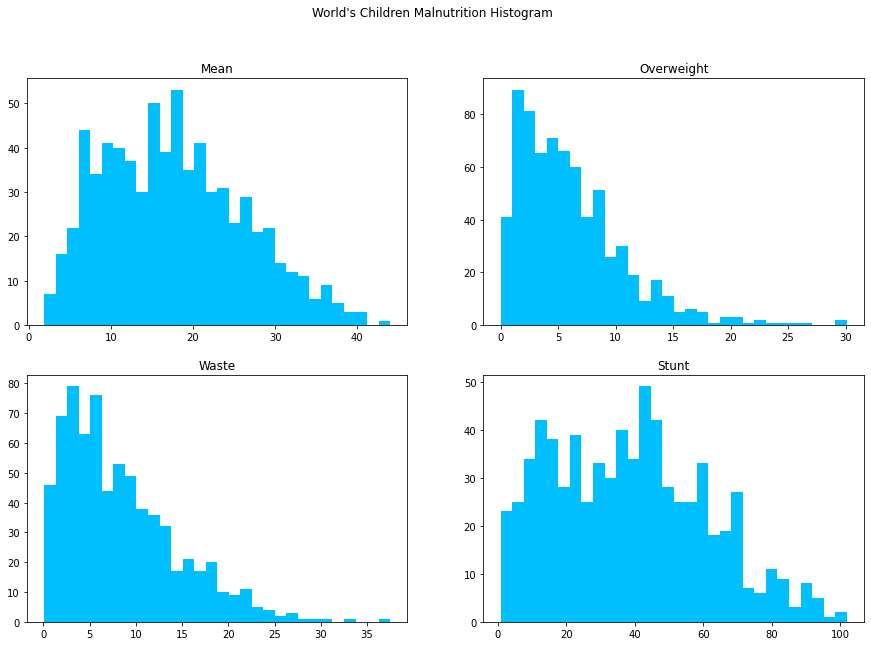

In [31]:
# now observe overweight/waste/stunt 
fig, axis = plt.subplots(2,2) 
fig.suptitle("World's Children Malnutrition Histogram")

# Mean
axis[0,0].hist(combined_df[mal_type[0]],bins=30,color='deepskyblue')
axis[0,0].set_title("Mean")
# Overweight
axis[0,1].hist(combined_df[mal_type[1]],bins=30,color='deepskyblue')
axis[0,1].set_title("Overweight")
# Waste
axis[1,0].hist(combined_df[mal_type[2]],bins=30,color='deepskyblue')
axis[1,0].set_title("Waste")
# Stunt
axis[1,1].hist(combined_df[mal_type[3]],bins=30,color='deepskyblue')
axis[1,1].set_title("Stunt")

fig.set_size_inches(15, 10)
plt.show()

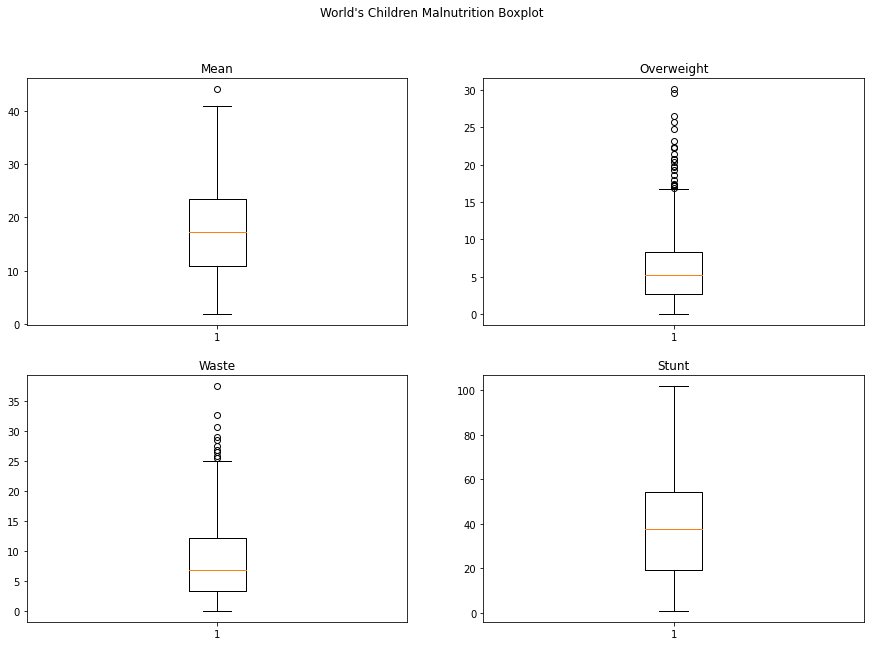

In [32]:
# now observe overweight/waste/stunt 
fig, axis2 = plt.subplots(2,2) 
fig.suptitle("World's Children Malnutrition Boxplot")

# Mean
axis2[0,0].boxplot(combined_df[mal_type[0]])
axis2[0,0].set_title("Mean")

# Overweight
axis2[0,1].boxplot(combined_df[mal_type[1]])
axis2[0,1].set_title("Overweight")

# Waste
axis2[1,0].boxplot(combined_df[mal_type[2]])
axis2[1,0].set_title("Waste")

# Stunt
axis2[1,1].boxplot(combined_df[mal_type[3]])
axis2[1,1].set_title("Stunt")

fig.set_size_inches(15, 10)
plt.show()


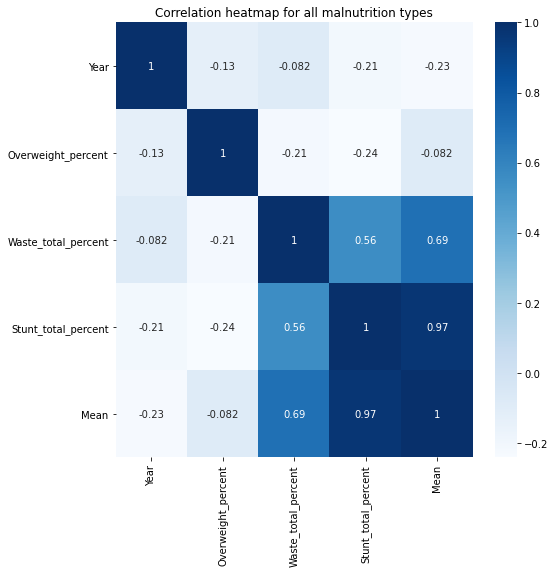

In [33]:
# observe correlation map
corr = combined_df.corr() # train is a pandas dataframe 
plt.figure(figsize = (8, 8))
heatmap(corr, cmap = 'Blues',annot=True)
plt.title('Correlation heatmap for all malnutrition types')
plt.show()

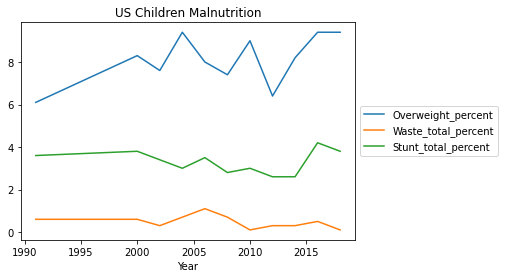

In [34]:
# Now Observe US first
country_df=combined_df.copy()
country_df.index = country_df["ISO Code"] #make the iso code as index 

country_df.loc['USA'].plot(x='Year', y=['Overweight_percent','Waste_total_percent','Stunt_total_percent'])
plt.title('US Children Malnutrition')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(10, 10)
plt.show()


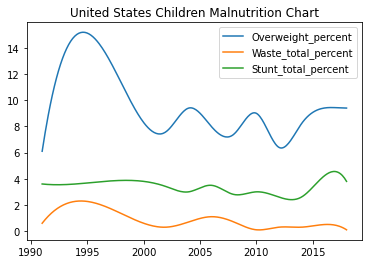

In [35]:
# create a function to smooth the graph later
# use interpld from scipy to smooth the lines

def countryGraph(countryISO):
    countryData=country_df.loc[countryISO]
    country_name=countryData['Country Name'][1]
    x=countryData['Year']
    X_=np.linspace(x.min(), x.max(),300)
    for i in range(1,4):
        y=countryData[mal_type[i]]
        smooth_model = interp1d(x, y, kind = "cubic")
        f=smooth_model(X_)
        plt.plot(X_,f)
    plt.title(country_name+str(' Children Malnutrition Chart'))
    plt.legend(mal_type[1:])
    plt.show()
countryGraph('USA')

In [36]:
# US has lower stunt and waste ratio but higher overweight problem for children under 5

In [37]:
# groupby countries, find the country with highest mean malnutrition value
# because the minimum of cubic spline required datapoint is 4, we want to filter the country with 4 or more years of report
country_count=combined_df.groupby(by=['ISO Code','Country Name'],as_index=False).count()
country_count.rename(columns={'Mean':'Count'},inplace=True)
country_count=country_count[country_count['Count']>=4]
country_count=country_count[['ISO Code','Count']]
display(country_count[:3])

,ISO Code,Count
2,ALB,4
4,ARM,5
5,AZE,4


In [38]:
#country_rank.sort_values(by='Mean',ascending=True,inplace=True)
country_rank=combined_df.groupby(by=['ISO Code','Country Name'],as_index=False).mean()
country_rank=country_rank.merge(country_count,how='inner',on='ISO Code')
country_rank=country_rank.sort_values(by='Mean')
display(country_rank[:3])

,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean,Count
80,USA,United States,2007.363636,8.109091,0.481818,3.300000,3.963636,11
36,KWT,Kuwait,2007.500000,8.328571,3.178571,5.807143,5.771429,14
30,JAM,Jamaica,2001.190476,5.923810,4.219048,11.504762,7.215873,21


In [39]:
# keep a record of the top 5 and bot 5 country with S&W mean for observation
top5=country_rank[:5]['Country Name'].tolist()
display(top5)
# the five country with least percentages of Stunt & Waste mean


['United States', 'Kuwait', 'Jamaica', 'Suriname', 'Jordan']

In [40]:
top5ISO=country_rank[:5]['ISO Code'].tolist()
display(top5ISO)
# 5 countries' corresponding iso code


['USA', 'KWT', 'JAM', 'SUR', 'JOR']

In [41]:
# Plot graphs to observe the trend for each malnutrition problem at country level for top 5 countries
#for i in top5ISO:
#    countryGraph(i)
    
#plt.show()
### ValueError: Expect x to not have duplicates??

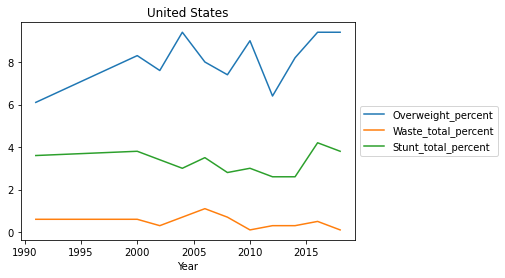

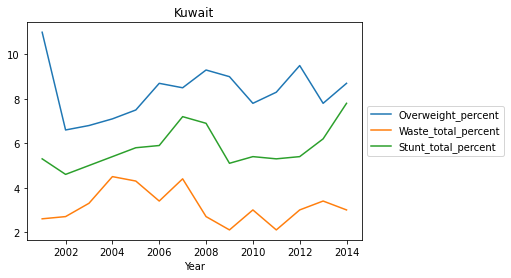

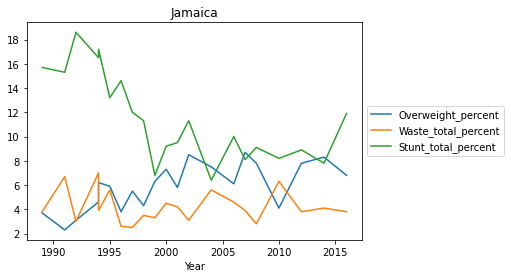

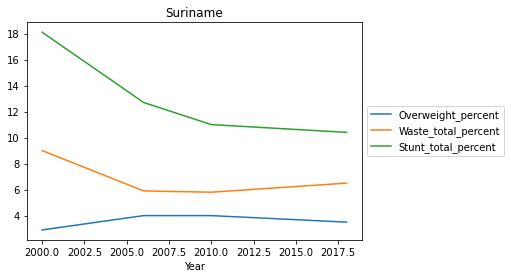

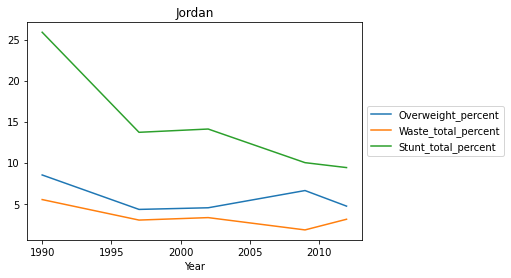

In [42]:
# Plot graphs to observe the trend for each malnutrition problem at country level for top 5 countries

for c in zip(top5,top5ISO):
    country_df.loc[c[1]].plot(x='Year', y=mal_type[1:])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(c[0])
plt.show()


In [43]:
bot5=country_rank[-5:]['Country Name'].tolist()
display(bot5) # the five country with high percentages of Stunt & Waste mean

['Madagascar', 'Pakistan', 'Burundi', 'Yemen', 'Timor-Leste']

In [44]:
bot5ISO=country_rank[-5:]['ISO Code'].tolist()
display(bot5ISO)

['MDG', 'PAK', 'BDI', 'YEM', 'TLS']

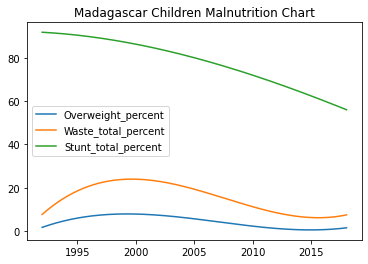

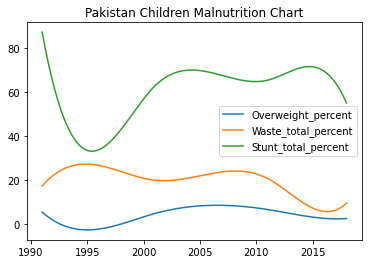

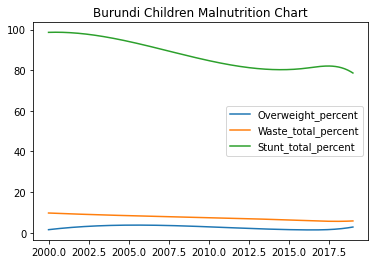

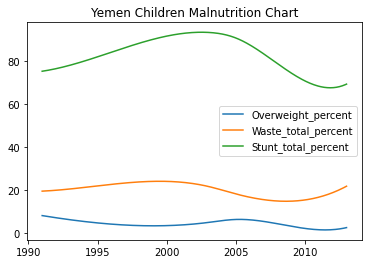

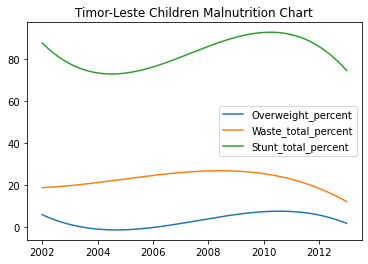

In [45]:
#graph bottom 5 countries malnutrition graphs
for i in bot5ISO:
    countryGraph(i)


### Continent Analysis

In [46]:
continent = pd.read_csv("countryContinent.csv")

continent = continent[["country", "continent"]]

joined = country_rank.merge(continent, left_on = "Country Name", right_on = "country")

joined = joined.drop(columns = "country")

In [47]:
display(joined[:3])

,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean,Count,continent
0,KWT,Kuwait,2007.500000,8.328571,3.178571,5.807143,5.771429,14,Asia
1,JAM,Jamaica,2001.190476,5.923810,4.219048,11.504762,7.215873,21,Americas
2,SUR,Suriname,2008.500000,3.600000,6.800000,13.050000,7.816667,4,Americas


In [48]:
by_continent = joined.groupby(["Year", "continent"], as_index = False).mean()

display(by_continent[:3])

,Year,continent,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean,Count
0,1999.000000,Asia,7.0875,4.262500,31.537500,14.295833,8.0
1,2000.500000,Europe,9.1000,4.725000,18.775000,10.866667,4.0
2,2000.666667,Americas,4.7500,2.133333,34.316667,13.733333,6.0


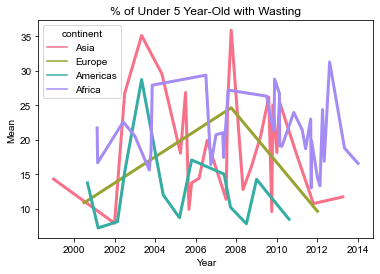

In [49]:
sns.lineplot(x="Year", y="Mean",
             hue="continent",data=by_continent, palette="husl", lw = 3).set(title = "% of Under 5 Year-Old with Wasting")

sns.set(rc={'figure.figsize':(15,6)})

sns.set_style("white")

In [50]:
## SHEENA TRYING SMOOTH THIS
#xc=by_continent['Year']
#Xc_=np.linspace(xc.min(), xc.max(),300)

#yc=by_continent['Mean']
#f1= interp1d(xc, yc, kind = "cubic")
#yc_=f1(Xc)

# Plotting the Graph
#plt.plot(Xc_, yc_)
# not working becuase x was repeated?? 
# https://stackoverflow.com/questions/68100959/plot-smooth-curve-with-duplicate-values-in-list

## Mapping

In [54]:
# import map
world_map = gpd.read_file(os.getcwd()+'\\World_Map\\World_Countries__Generalized_.shp')

In [68]:
map_all = world_map.merge(combined_df, how='left', left_on='COUNTRYAFF', right_on='Country Name')
print('Verifying data has combined')
display(map_all.head(1))

Verifying data has combined


,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry,ISO Code,Country Name,Sex,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean
0,1,American Samoa,AS,United States,US,0.600124,0.01372,"POLYGON ((-170.74390 -14.37555, -170.74942 -14...",USA,United States,T,1991.0,6.1,0.6,3.6,3.433333


In [69]:
print('Overweight observations range', np.nanmin(map_all['Overweight_percent'].values), '% to', np.nanmax(map_all['Overweight_percent'].values), '%.')
print('Wasted observations range', np.nanmin(map_all['Waste_total_percent'].values), '% to', np.nanmax(map_all['Waste_total_percent'].values), '%.')
print('Stunted observations range', np.nanmin(map_all['Stunt_total_percent'].values), '% to', np.nanmax(map_all['Stunt_total_percent'].values), '%.')

Overweight observations range 0.1 % to 30.1 %.
Wasted observations range 0.1 % to 37.5 %.
Stunted observations range 0.9 % to 101.9 %.


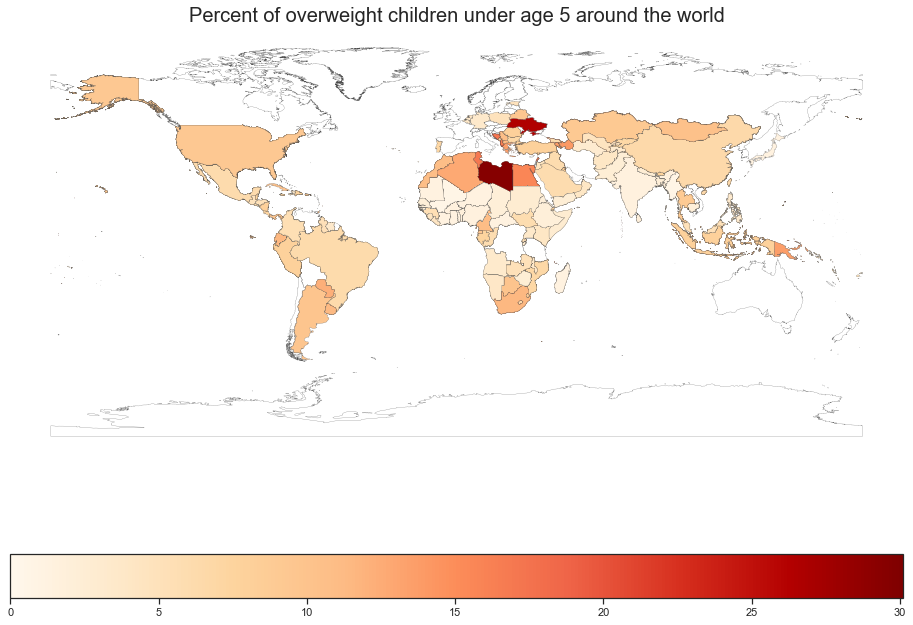

In [60]:
# map with all overweight indicators
vmin, vmax = 0, np.nanmax(map_all['Overweight_percent'].values)

figo, axo = plt.subplots(1, figsize = (16,12))
map_all.plot(column='Overweight_percent', cmap='OrRd', ax=axo, linewidth=0.2, edgecolors='0.3')
bar_infoo = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
axo.set_title('Percent of overweight children under age 5 around the world', fontdict={'fontsize':20})
axo.set_axis_off()
bar_infoo._A = []
cbar = figo.colorbar(bar_infoo, orientation='horizontal')

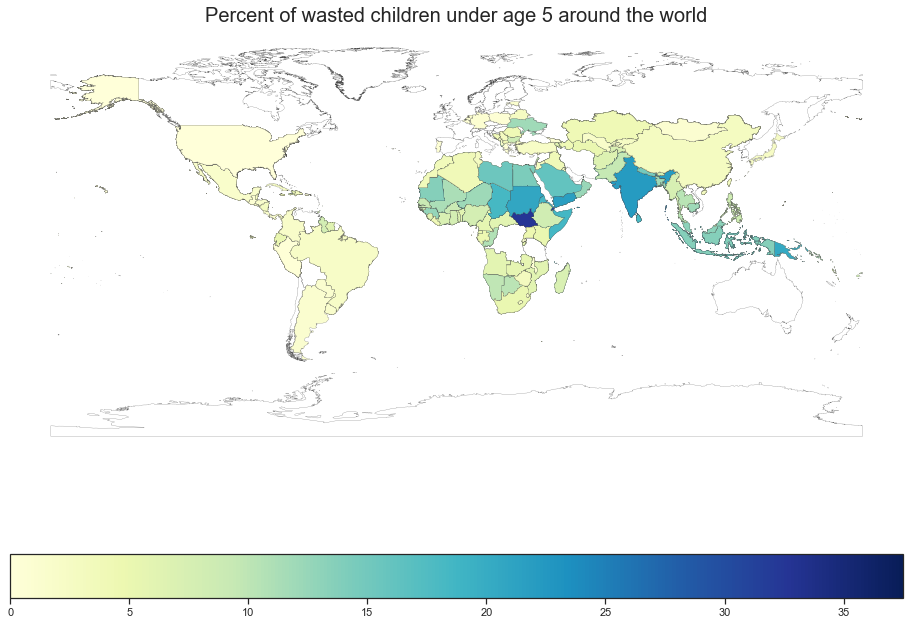

In [65]:
# map with all waste indicators
vmin, vmax = 0, np.nanmax(map_all['Waste_total_percent'].values)

figw, axw = plt.subplots(1, figsize = (16,12))
map_all.plot(column='Waste_total_percent', cmap='YlGnBu', ax=axw, linewidth=0.2, edgecolors='0.3')
bar_infow = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
axw.set_title('Percent of wasted children under age 5 around the world', fontdict={'fontsize':20})
axw.set_axis_off()
bar_infow._A = []
cbar = figw.colorbar(bar_infow, orientation='horizontal')

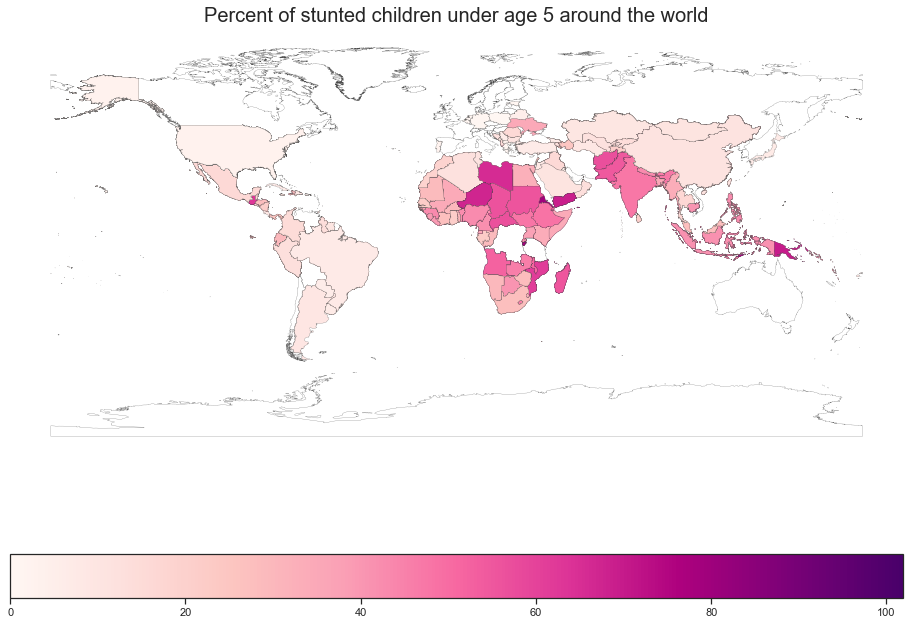

In [62]:
# map with all stunt indicators
vmin, vmax = 0, np.nanmax(map_all['Stunt_total_percent'].values)

figs, axs = plt.subplots(1, figsize = (16,12))
map_all.plot(column='Stunt_total_percent', cmap='RdPu', ax=axs, linewidth=0.2, edgecolors='0.3')
bar_infos = plt.cm.ScalarMappable(cmap='RdPu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
axs.set_title('Percent of stunted children under age 5 around the world', fontdict={'fontsize':20})
axs.set_axis_off()
bar_infos._A = []
cbar = figs.colorbar(bar_infos, orientation='horizontal')

## Animation

In [56]:
# list of years
min_year = int(map_all['Year'].min())
max_year = int(map_all['Year'].max())+1
list_of_years = list(range(min_year, max_year))
print('Years range from', min(list_of_years), 'to', max(list_of_years))

Years range from 1986 to 2020


In [57]:
# list of countries
countries = map_all['COUNTRYAFF'].unique()
print('There are', len(countries), 'countries listed.')

There are 197 countries listed.


In [58]:
# save all the maps in the pictures folder
output_path = os.getcwd()+'\\pictures'
filenames = []

In [59]:
# algorithm to make a map for each year and save as jpg
def make_maps(map_col, color, ax, list_of_years = list(range(2000,2020))):
    # start the for loop to create one map per year
    for year in list_of_years:
        # narrow the data to the year desired
        yearly = combined_df.loc[combined_df['Year'] == year].reset_index(drop=True)
        maps = world_map.merge(yearly, how='left', left_on='COUNTRYAFF', right_on='Country Name')
        
        # normalize across all years
        vmin = min(combined_df[map_col])
        vmax = max(combined_df[map_col])

        # create map
        fig = maps.plot(column=map_col,
                        cmap=color,
                        figsize=(16,12),
                        linewidth=0.3,
                        edgecolor='0.3',
                        ax=ax,
                        norm=plt.Normalize(vmin=vmin, vmax=vmax))
        
        # add a title
        fig.set_title(map_col + ' children under age 5 in ' + str(year), \
                  fontdict={'fontsize': '20',
                             'fontweight' : '3'})

        # remove axis of chart
        fig.set_axis_off()
        
        # this will save the figure as a high-res jpg
        filename = str(year)+'_'+map_col+'.jpg'
        filepath = os.path.join(output_path, filename)
        filenames.append(filename)
        chart = fig.get_figure()
        chart.savefig(filepath, dpi=300)

In [60]:
make_maps('Overweight_percent', 'OrRd', axo, list_of_years)

<Figure size 1080x432 with 0 Axes>

In [61]:
make_maps('Waste_total_percent', 'YlGnBu', axw, list_of_years)

<Figure size 1080x432 with 0 Axes>

In [62]:
make_maps('Stunt_total_percent', 'RdPu', axs, list_of_years)

<Figure size 1080x432 with 0 Axes>

In [63]:
# pull the created pictures into a gif
import glob
from PIL import Image

def make_gif(fp_in, fp_out, duration = 400, loop = 3):
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=duration, loop=loop)

In [64]:
# filepaths for overweight
o_fp_in = os.getcwd()+'\\pictures\\*_Overweight*.jpg'
o_fp_out = os.getcwd()+'\\overweight.gif'

#make overweight gif
make_gif(o_fp_in, o_fp_out)

In [65]:
# filepaths for wasted
w_fp_in = os.getcwd()+'\\pictures\\*_Waste*.jpg'
w_fp_out = os.getcwd()+'\\waste.gif'

#make wasted gif
make_gif(w_fp_in, w_fp_out)

In [66]:
# filepaths for stunted
s_fp_in = os.getcwd()+'\\pictures\\*_Stunt*.jpg'
s_fp_out = os.getcwd()+'\\stunt.gif'

#make stunted gif
make_gif(s_fp_in, s_fp_out)

![SegmentLocal](overweight.gif "segment")

![SegmentLocal](waste.gif "segment")

![SegmentLocal](stunt.gif "segment")

### Covid Analysis

In [67]:
# combine with COVID

In [68]:
###### 
# Download covid vaccine rate data to covid_data from https://ourworldindata.org/covid-vaccinations
covid_data=pd.read_csv("owid-covid-data.csv")
covid_data.tail(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
151543,ZWE,Africa,Zimbabwe,2021-12-28,207548.0,2099.0,1397.143,4940.0,32.0,17.286,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
151544,ZWE,Africa,Zimbabwe,2021-12-29,207548.0,0.0,1163.429,4940.0,0.0,16.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
151545,ZWE,Africa,Zimbabwe,2021-12-30,211728.0,4180.0,1483.429,4997.0,57.0,20.286,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
151546,ZWE,Africa,Zimbabwe,2021-12-31,213258.0,1530.0,1503.143,5004.0,7.0,19.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
151547,ZWE,Africa,Zimbabwe,2022-01-01,214214.0,956.0,1495.429,5017.0,13.0,18.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [69]:
#before 12/31/2020, the total number of cases for each countries
covid_data=covid_data[covid_data['date']<'2021-01-01']
covid_2020=covid_data.groupby(by='iso_code').max()
display(covid_2020[:5])


,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
iso_code,,,,,,,,,,,,,,,,,,,,,
ABW,North America,Aruba,2020-12-31,5489.0,176.0,90.143,49.0,3.0,1.000,51205.747,...,NaN,NaN,NaN,NaN,76.29,NaN,66.2,14.96,59.84,617.566118
AFG,Asia,Afghanistan,2020-12-31,52330.0,1241.0,758.571,2189.0,49.0,26.429,1313.655,...,NaN,NaN,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN
AGO,Africa,Angola,2020-12-31,17553.0,355.0,261.857,405.0,12.0,4.571,517.275,...,NaN,NaN,26.664,NaN,61.15,0.581,NaN,NaN,NaN,NaN
AIA,North America,Anguilla,2020-12-31,13.0,3.0,0.571,NaN,NaN,NaN,859.504,...,NaN,NaN,NaN,NaN,81.88,NaN,NaN,NaN,NaN,NaN
ALB,Europe,Albania,2020-12-31,58316.0,879.0,799.143,1181.0,19.0,16.286,20298.413,...,7.1,51.2,NaN,2.89,78.57,0.795,5812.4,26.67,120.15,2023.158207


In [70]:
norm_covid_2020=covid_2020.copy()
# since cases number varies alot, apply z-score standardlization to total_cases column to normalize the case number
norm_covid_2020=norm_covid_2020.sort_values(by='total_cases')
norm_covid_2020['norm_total_cases'] = (norm_covid_2020['total_cases'] - norm_covid_2020['total_cases'].mean())\
                                    / (norm_covid_2020['total_cases'].std())    

display(norm_covid_2020)



,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,norm_total_cases
iso_code,,,,,,,,,,,,,,,,,,,,,
VUT,Oceania,Vanuatu,2020-12-31,1.0,1.0,0.143,NaN,NaN,NaN,3.180,...,34.500,25.209,NaN,70.47,0.609,NaN,NaN,NaN,NaN,-0.216846
WSM,Oceania,Samoa,2020-12-31,2.0,1.0,0.143,NaN,NaN,NaN,9.993,...,38.100,NaN,NaN,73.32,0.715,NaN,NaN,NaN,NaN,-0.216846
WLF,Oceania,Wallis and Futuna,2020-12-31,4.0,1.0,0.143,NaN,NaN,NaN,360.555,...,NaN,NaN,NaN,79.94,NaN,NaN,NaN,NaN,NaN,-0.216846
MHL,Oceania,Marshall Islands,2020-12-31,4.0,3.0,0.429,NaN,NaN,NaN,67.094,...,NaN,82.502,2.700,73.70,0.704,NaN,NaN,NaN,NaN,-0.216846
SHN,Africa,Saint Helena,2020-12-31,4.0,2.0,0.286,NaN,NaN,NaN,656.276,...,NaN,NaN,NaN,80.56,NaN,NaN,NaN,NaN,NaN,-0.216846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OWID_NAM,NaN,North America,2020-12-31,23150275.0,286075.0,245712.143,512711.0,5212.0,3668.429,38804.897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.976719
OWID_EUR,NaN,Europe,2020-12-31,23859991.0,345394.0,293718.143,545520.0,6443.0,5002.714,31857.370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.074624
OWID_UMC,NaN,Upper middle income,2020-12-31,25097583.0,212105.0,182072.714,714172.0,5584.0,3686.714,9984.427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.245349


,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,norm_total_cases
iso_code,,,,,,,,,,,,,,,,,,,,,
VUT,Oceania,Vanuatu,2020-12-31,1.0,1.0,0.143,NaN,NaN,NaN,3.180,...,34.5,25.209,NaN,70.47,0.609,NaN,NaN,NaN,NaN,-0.216846
WSM,Oceania,Samoa,2020-12-31,2.0,1.0,0.143,NaN,NaN,NaN,9.993,...,38.1,NaN,NaN,73.32,0.715,NaN,NaN,NaN,NaN,-0.216846
WLF,Oceania,Wallis and Futuna,2020-12-31,4.0,1.0,0.143,NaN,NaN,NaN,360.555,...,NaN,NaN,NaN,79.94,NaN,NaN,NaN,NaN,NaN,-0.216846
MHL,Oceania,Marshall Islands,2020-12-31,4.0,3.0,0.429,NaN,NaN,NaN,67.094,...,NaN,82.502,2.7,73.70,0.704,NaN,NaN,NaN,NaN,-0.216846
SHN,Africa,Saint Helena,2020-12-31,4.0,2.0,0.286,NaN,NaN,NaN,656.276,...,NaN,NaN,NaN,80.56,NaN,NaN,NaN,NaN,NaN,-0.216846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OWID_ASI,NaN,Asia,2020-12-31,20716183.0,146135.0,129001.000,337854.0,2524.0,1848.714,4428.006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.640938
OWID_NAM,NaN,North America,2020-12-31,23150275.0,286075.0,245712.143,512711.0,5212.0,3668.429,38804.897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.976719
OWID_EUR,NaN,Europe,2020-12-31,23859991.0,345394.0,293718.143,545520.0,6443.0,5002.714,31857.370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.074624


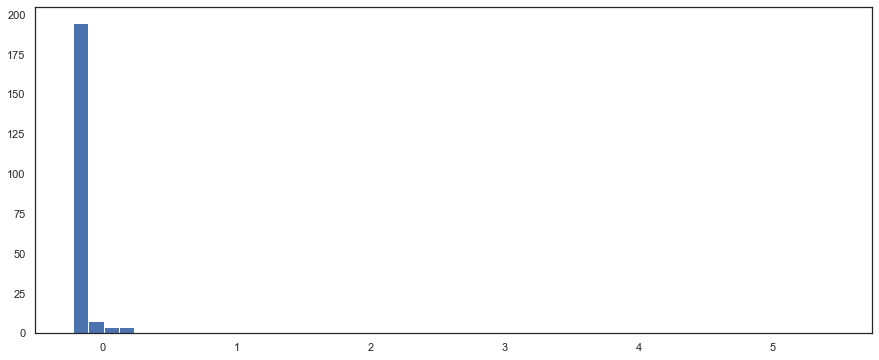

In [71]:
#Observed the world data on last row, remove for outlier data point
norm_covid_2020=norm_covid_2020[:-1] 
display(norm_covid_2020)
plt.hist(norm_covid_2020['norm_total_cases'],bins=50)
plt.show()


#### Highest % of COVID deaths in the world

In [72]:
covid = pd.read_csv("owid-covid-data.csv")[["location", "date", "new_deaths"]]

covid["date"] = pd.to_datetime(covid["date"]).dt.year

top_10_covid = covid.groupby(["location", "date"], as_index = False).sum()

display(top_10_covid[:3])

,location,date,new_deaths
0,Afghanistan,2020,2189.0
1,Afghanistan,2021,5167.0
2,Afghanistan,2022,0.0


In [73]:
worldpop = pd.read_csv("Worldpop.csv")

worldpop["PopTotal"] = worldpop["PopTotal"].astype(int)

display(worldpop[:3])

,Location,Time,PopTotal
0,Afghanistan,2020,38928
1,Afghanistan,2021,39943
2,Africa,2020,1340598


Join total population to covid deaths for comparison

In [74]:
top_10_covid = worldpop.merge(top_10_covid, left_on = ["Location", "Time"], right_on = ["location", "date"])

top_10_covid = top_10_covid.drop(columns = ["date", "location"])

In [75]:
display(top_10_covid[:3])

,Location,Time,PopTotal,new_deaths
0,Afghanistan,2020,38928,2189.0
1,Afghanistan,2021,39943,5167.0
2,Africa,2020,1340598,65468.0


In [76]:
# population total in 1000's 

top_10_covid["deaths percentage"] = (top_10_covid["new_deaths"]/(top_10_covid["PopTotal"]*1000))

top_10_covid = top_10_covid[top_10_covid["Location"] != "World"]

covid_countries = top_10_covid.sort_values(by = "deaths percentage", ascending = False)

In [77]:
covid_countries = covid_countries[:10]

display(covid_countries[:3])

,Location,Time,PopTotal,new_deaths,deaths percentage
59,Bulgaria,2021,6892,23379.0,0.003392
282,Peru,2021,33283,109583.0,0.003292
164,Hungary,2021,9627,29649.0,0.003080


In [78]:
covid_trend = top_10_covid[top_10_covid["Location"].isin(covid_countries["Location"].unique())]

display(covid_trend[:3])

,Location,Time,PopTotal,new_deaths,deaths percentage
50,Bosnia and Herzegovina,2020,3280,4050.0,0.001235
51,Bosnia and Herzegovina,2021,3267,9392.0,0.002875
58,Bulgaria,2020,6948,7576.0,0.001090


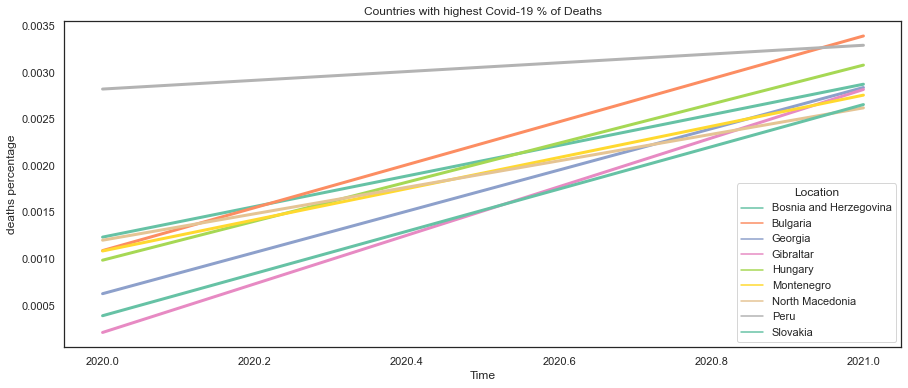

In [79]:
sns.lineplot(x="Time", y="deaths percentage",
             hue="Location",data=covid_trend, palette="Set2", lw =3).set(title = "Countries with highest Covid-19 % of Deaths")

sns.set(rc={'figure.figsize':(15,6)})

sns.set_style("white")

In [80]:
# countries with most covid deaths 
continent = pd.read_csv("countryContinent.csv")

continent = continent[["country", "continent"]]

covid_deaths = covid_trend.merge(continent, left_on = "Location", right_on = "country")

covid_deaths = covid_deaths.drop(columns = ["country"])

display(covid_deaths["continent"].unique())

array(['Europe', 'Asia', 'Americas'], dtype=object)